In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm, theano.tensor as tt
from pymc3.backends import Text
import matplotlib.pyplot as plt

%matplotlib inline

## Pre-Processing

In [40]:
ts = pd.read_csv('./data/ts14-15.csv')
ts = ts.drop('Unnamed: 0', 1)

# Build team index
teams = ts.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

ts = pd.merge(ts, teams, left_on='home_team', right_on='team', how='left')
ts = ts.rename(columns = {'i': 'i_home'}).drop('team', 1)
ts = pd.merge(ts, teams, left_on='away_team', right_on='team', how='left')
ts = ts.rename(columns = {'i': 'i_away'}).drop('team', 1)

ts = ts.sort_values(by='kick_off', ascending=1)

# Observed goals stats (Eyeball Poisson)
observed_home_goals = ts.home_score.values
observed_away_goals = ts.away_score.values

home_team = ts.i_home.values
away_team = ts.i_away.values

num_teams = len(ts.i_home.drop_duplicates())
num_games = len(home_team)

# Add back to back fixture round index t
fixtures_per_round = num_teams/2
num_rounds = 38

rounds = np.array([[x]*(fixtures_per_round) for x in range(1,39)]).flatten()
ts['t'] = 1
ts['t'] = rounds

# Reshape observation and team index arrays
grouped = ts.groupby('t')

observed_home_goals = np.zeros((num_rounds,fixtures_per_round))
observed_away_goals = np.zeros((num_rounds,fixtures_per_round))
home_team = np.zeros((num_rounds,fixtures_per_round))
away_team = np.zeros((num_rounds,fixtures_per_round))

for t, group in grouped:
    observed_home_goals[t-1] = group.home_score.values
    observed_away_goals[t-1] = group.away_score.values
    home_team[t-1] = group.i_home.values
    away_team[t-1] = group.i_away.values
    
observed_home_goals = observed_home_goals.astype(np.int64)
observed_away_goals = observed_away_goals.astype(np.int64)
home_team = home_team.astype(np.int64)
away_team = away_team.astype(np.int64)

T = observed_home_goals.shape[0]

# Calculate time delta between games
# Ordered ascending dates with team
ts_home = ts[['home_team', 'kick_off']]
ts_away = ts[['away_team', 'kick_off']]

ts_home.columns = ['team', 'date']
ts_away.columns = ['team', 'date']

dates = ts_home.append(ts_away)

dates = dates.sort_values(by='date', ascending=1)

dates = dates.reset_index(drop=False)

dates['date'] = pd.to_datetime(dates['date'])
dates['time_delta'] = 0

# Group by team
dates_grouped = dates.groupby('team')

# calculate time delta
for name, group in dates_grouped:
    time_delta = group['date'].diff()
    days = (time_delta / np.timedelta64(1, 'D'))
    days = days.fillna(0).astype(int)
    dates.ix[days.index,'time_delta'] = days

# add to original dataframe where (team in home and date OR team in away and date)
dates = dates.set_index('index')

ts['home_time_delta'] = 0
ts['away_time_delta'] = 0

dates0 = dates.ix[dates.index.duplicated()]
dates1 = dates.ix[-dates.index.duplicated()]

ts = ts.sort_index()

dates0 = dates0.sort_index()
dates1 = dates1.sort_index()

ts.set_value(dates0['team'] == ts['home_team'],['home_time_delta'],dates0['time_delta'])
ts.set_value(dates1['team'] == ts['home_team'],['home_time_delta'],dates1['time_delta'])

ts.set_value(dates0['team'] == ts['away_team'],['away_time_delta'],dates0['time_delta'])
ts.set_value(dates1['team'] == ts['away_team'],['away_time_delta'],dates1['time_delta'])

# Sort by kick-off date
ts = ts.sort_values(by='kick_off', ascending=1)

ts[0:19]

,home_score,away_score,kick_off,home_team,away_team,i_home,i_away,t,home_time_delta,away_time_delta
290,0,1,2014-08-16,Stoke City,Aston Villa,15,5,1,0,0
56,1,2,2014-08-16,Manchester United,Swansea City,2,19,1,0,0
274,0,1,2014-08-16,West Ham United,Tottenham Hotspur,14,8,1,0,0
10,2,1,2014-08-16,Arsenal,Crystal Palace,0,11,1,0,0
340,0,1,2014-08-16,Queens Park Rangers,Hull City,17,18,1,0,0
235,2,2,2014-08-16,Leicester City,Everton,12,7,1,0,0
202,2,2,2014-08-16,West Bromwich Albion,Sunderland,10,13,1,0,0
62,2,1,2014-08-17,Liverpool,Southampton,3,6,1,0,0
84,0,2,2014-08-17,Newcastle United,Manchester City,4,9,1,0,0
305,1,3,2014-08-18,Burnley,Chelsea,16,1,1,0,0


## Model Definition and Sampling

In [3]:
# If run with T == 1, only fit timestep 1 without AR
starting_points = []
models = []
trace_len = 18000

for T in range(1,6):
    print "\nTrain including week: %d, Predict week: %d" %(T-1, T)
    
    with pm.Model() as exp_2:
        # global model parameters
        home = pm.Normal('home', mu=0, tau=0.0001)
        tau_att = pm.Gamma('tau_att', alpha=0.1, beta=0.1)
        tau_def = pm.Gamma('tau_def', alpha=0.1, beta=0.1)
        intercept = pm.Normal('intercept', mu=0, tau=0.0001)

        # Make auto-regressive
        # Each t indexes a home or away fixture for each team (10 games with 20 teams)
        # [1] Define t0
        # TODO: Incorporate time_deltas in tau? Or is it just 1 in t1?
        atts_ni = [pm.Normal("atts_ni0", mu = 0, tau = tau_att, shape = num_teams)]
        defs_ni = [pm.Normal("defs_ni0", mu = 0, tau = tau_def, shape = num_teams)]

        # Identifiability
        atts = [pm.Deterministic('atts0', atts_ni[0] - tt.mean(atts_ni[0]))]
        defs = [pm.Deterministic('defs0', defs_ni[0] - tt.mean(defs_ni[0]))]

        home_thetas = [tt.exp(intercept + home + atts[0][home_team[0,:]] + defs[0][away_team[0,:]])]
        away_thetas = [tt.exp(intercept + atts[0][away_team[0,:]] + defs[0][home_team[0,:]])]

        home_points = [pm.Poisson('home_points0', mu=home_thetas[0], observed=observed_home_goals[0,:])]
        away_points = [pm.Poisson('away_points0', mu=away_thetas[0], observed=observed_away_goals[0,:])]

        # [2] Define t1-T: "stack plates"
        # [b] take time delta adjusted variance into account
        #     (http://mathworld.wolfram.com/RandomWalk1-Dimensional.html)
        # Is 0 for time_delta ok, since we are in log space?
        # atts_ni ~ latent attack paramter not respecting the identifiability constraint yet
        # Keep innovation variance global
        # For first run range(1,1) won't execute
        for t in range(1,T):
            
            # assumption 1: tau_att will be a <num_teams> sized vector of priors
            # assumption 2: atts_ni are ordered by team index (the mask later picks the right parameters)
            #                - hence order time deltas by team index
            # Find round deltas: Order team deltas by ascending team index
            # Need index t+1 since t's start with 1 in the dataframe
            home_ix = ts[(ts.t == t+1)]['i_home'].values
            away_ix = ts[(ts.t == t+1)]['i_away'].values
            home_deltas = ts[(ts.t == t+1)]['home_time_delta'].values
            away_deltas = ts[(ts.t == t+1)]['away_time_delta'].values        
            ix = np.concatenate((home_ix, away_ix))
            deltas = np.concatenate((home_deltas, away_deltas))
            mask = np.argsort(ix)
            round_deltas = deltas[mask]

            # Random walks with TIME DRIFT
            atts_ni.append(pm.Normal("atts_ni{0}".format(t),
                                     mu = atts[t-1],
                                     tau = tau_att * np.sqrt(round_deltas),
                                     shape = num_teams))
            defs_ni.append(pm.Normal("defs_ni{0}".format(t),
                                     mu = defs[t-1],
                                     tau = tau_def * np.sqrt(round_deltas),
                                     shape = num_teams))

            atts.append(pm.Deterministic("atts{0}".format(t), atts_ni[t] - tt.mean(atts_ni[t])))
            defs.append(pm.Deterministic("defs{0}".format(t), defs_ni[t] - tt.mean(defs_ni[t])))

            home_thetas.append(tt.exp(intercept + home + atts[t][home_team[t,:]] + defs[t][away_team[t,:]]))
            away_thetas.append(tt.exp(intercept + atts[t][away_team[t,:]] + defs[t][home_team[t,:]]))

            # likelihood of observed data
            home_points.append(pm.Poisson("home_points{0}".format(t), mu=home_thetas[t], observed=observed_home_goals[t,:]))
            away_points.append(pm.Poisson("away_points{0}".format(t), mu=away_thetas[t], observed=observed_away_goals[t,:]))

        # Sampling
        # If no previous model runs, find map as starting point
        # otherwise use estimates from previous model run
        # No starting point for atts_ni{t+1} and defs respectively, could use atts_ni{t} estimates instead
        if (T == 1):
            start = pm.find_MAP()
            starting_points.append(start)
        else:
            start = {key: np.mean(trace[key], axis=0) for key in start.keys()}
            starting_points.append(start)
            
        step = pm.Metropolis()
        db = Text("trace_exp_2_{0}".format(T))
        trace = pm.sample(trace_len, step, start=start, trace=db)
        
        # Save away model for later analysis
        models.append(exp_2)


Train including week: 0, Predict week: 1
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.
 [-----------------100%-----------------] 18000 of 18000 complete in 19.5 sec
Train including week: 1, Predict week: 2
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.
 [-----------------100%-----------------] 18000 of 18000 complete in 32.3 sec
Train including week: 2, Predict week: 3
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.
 [-----------------100%-----------------] 18000 of 18000 complete in 46.7 sec
Train including week: 3, Predict week: 4
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def

## Analyse Convergence

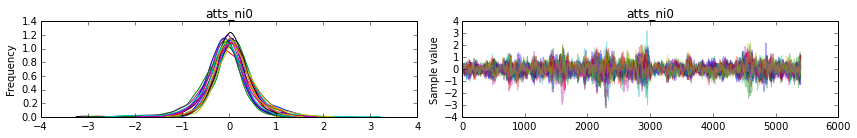

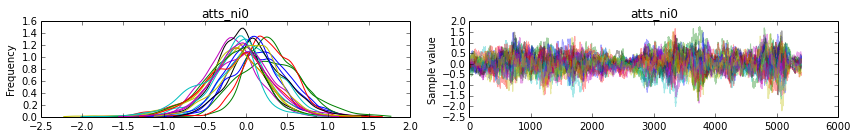

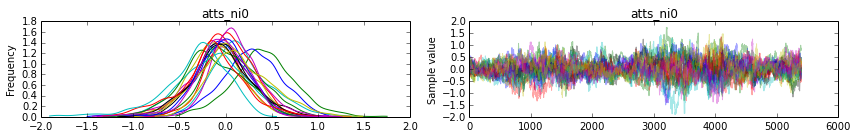

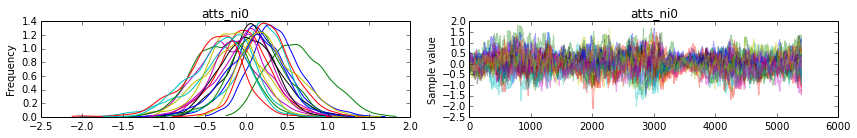

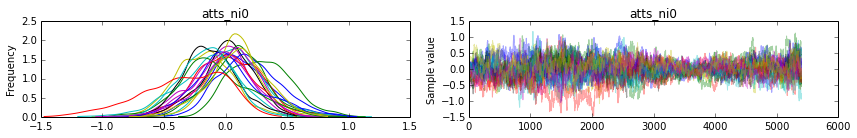

In [5]:
burn = int(trace_len * 0.1)
thin = 3

# Save traces "out of context" for prediction
traces = []

for k, m in enumerate(models):
    with m:
        tracename = "trace_exp_2_" + str(k+1)
        trace = pm.backends.text.load(tracename)
        trace = trace[burn::thin]
        traces.append(trace)
        pm.traceplot(trace, [atts_ni[0]])

## Predictive Analysis: 1-Step ahead prediction

In [43]:
from scipy.stats import poisson

# Week-wise 1-step ahead prediction
num_weeks = 5
num_games = num_weeks * 10
ll = 0

for w in range(0, num_weeks):    
    t = traces[w]

    home_mean = t['home'].mean()
    intercept_mean = t['intercept'].mean()
    
    # Only looking at strength parameter of present week!? -> D-Separated with t-1 parameters???
    defs_mean = t["atts" + str(w)].mean(axis=0)
    atts_mean = t["defs" + str(w)].mean(axis=0)

    # Given week 1, predict week 2 (ten games a week)
    # Only looking at strength parameter of present week!? -> D-Separated with t-1 parameters???
    lbda_home = np.exp(home_mean + atts_mean[home_team[w]] + defs_mean[away_team[w]] + intercept_mean)
    lbda_away = np.exp(atts_mean[away_team[w]] + defs_mean[home_team[w]] + intercept_mean)

    # Prediction: Sampling from Independent Poisson
    p_home = poisson.pmf(observed_home_goals[1], lbda_home)
    p_away = poisson.pmf(observed_away_goals[1], lbda_away)

    # Multiply all home and away probabilites as well as the ten games, transform to log space 
    ll += np.log(np.prod(p_home * p_away))

print "Average Log-Likelihood of Season 14/15: " + str(ll / num_games)

Average Log-Likelihood of Season 14/15: -3.07203321131


## Descriptive Analysis: Evolution of team strength parameters

In [ ]:
# Same evolution plot as before, after training on all observations